In [1]:
from lib.service.database import DatabaseService
from lib.service.database.defaults import instance_1_config

db = DatabaseService(instance_1_config)
await db.wait_till_running()

engine = db.engine()

In [2]:
import pandas as pd

pd.read_sql("""SELECT gcc_name FROM abs_main_structures.GCCSA""", engine).head()

,gcc_name
0,Greater Sydney
1,Rest of NSW
2,No usual address (NSW)
3,Migratory - Offshore - Shipping (NSW)
4,Greater Melbourne


<Axes: >

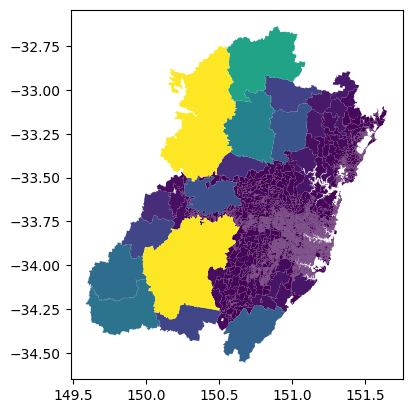

In [3]:
import geopandas as gpd

gpd.read_postgis("""

SELECT DISTINCT sa.area_sqkm, sa.geometry
  FROM abs_main_structures.sa1 sa
  JOIN abs_main_structures.gccsa ag 
    ON ST_Intersects(sa.geometry, ag.geometry)
 WHERE ag.gcc_name = 'Greater Sydney'
 
""", engine, geom_col='geometry').plot(column='area_sqkm')

In [4]:
import pandas as pd

pd.concat([
    pd.read_sql(f"""
        SELECT '{schema}' as schema, '{row['table_name']}' as name, COUNT(*) as count
          FROM {schema}.{row['table_name']}
    """, engine)
    for schema in [
        'abs_main_structures',
        'non_abs_main_structures',
        'nsw_valuer_general',
        'gnaf',
    ]
    for index, row in pd.read_sql(f"""
        SELECT table_name 
          FROM information_schema.tables
         WHERE table_schema = '{schema}'
    """, engine).iterrows()
]).reset_index(drop=True)

,schema,name,count
0,abs_main_structures,state,10
1,abs_main_structures,gccsa,35
2,abs_main_structures,sa4,108
3,abs_main_structures,sa3,359
4,abs_main_structures,sa2,2473
...,...,...,...
58,gnaf,street_locality_alias,40050
59,gnaf,street_locality_alias_type_aut,2
60,gnaf,street_locality_point,713093
61,gnaf,street_suffix_aut,19


,property_description,land_parcel_id,property_name,property_id,zone_code,rank,per_m2,land_value,area,name,unit,house,street,suburb,postcode,geometry


/var/folders/l1/1wl5vmds75qfv945_bs13x6w0000gn/T/ipykernel_30647/80225568.py:157: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  bh_df.plot(


<Axes: >

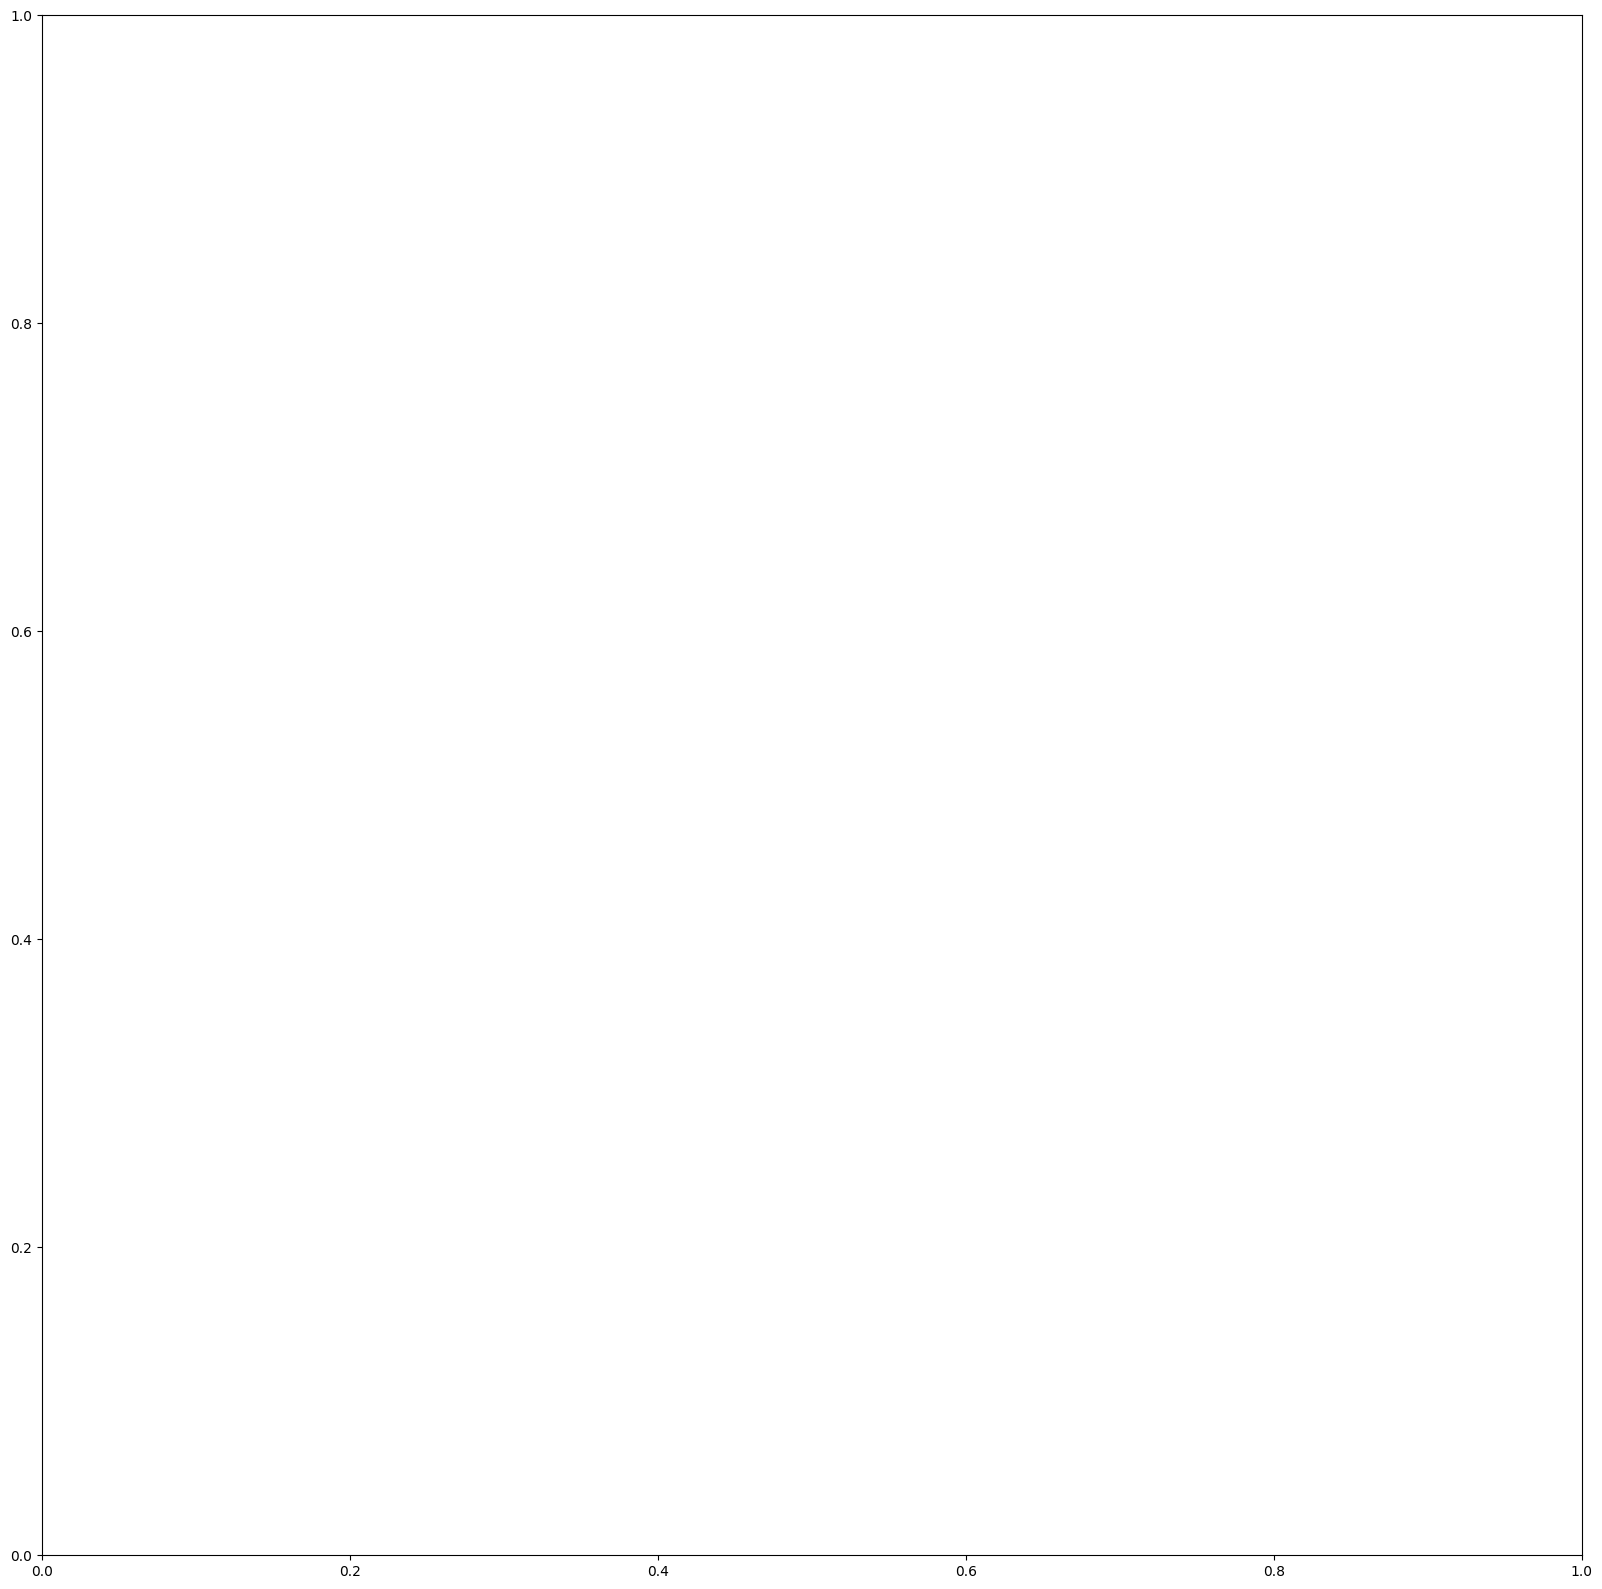

In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text

should_be_hectares = (
    # Public schools
    '2109562',
    '3045369',
    
    # Hospitial
    '1915895',

    # Random houses
    '2013895', # 301/807604, 3.507sqm, (a house)
    '2007459', # 286/230712, 8.230sqm, (a house)
    '1976991', # 3/34169, 22.3sqm, (a house)
    '1984039', # 4/6700, 46.8sqm, (a house)
    
    # Unsure what happened here
    '4062073',
    '3803977',
    '1935693',
    '1986173', # 1063/752015, 2.116sqm, (a field)
    '1390065', # 130/1007385, 15.3sqm
)

bh_df = gpd.read_postgis(text("""
  WITH lga_mb AS (
       SELECT asbmb.*
         FROM abs_main_structures.Meshblock asbmb
         LEFT JOIN non_abs_main_structures.lga_2024 lga ON ST_Intersects(asbmb.geometry, lga.geometry)
        WHERE lga.lga_name IN :lga_names
          AND (ST_Area(ST_Intersection(asbmb.geometry, lga.geometry)) / ST_Area(asbmb.geometry)) > 0.5
  ), 
  
  p_in_lga AS (
       SELECT DISTINCT ON (p.property_id, lp.land_parcel_id) p.*, asbmb.*, lp.land_parcel_id
         FROM nsw_valuer_general.property p
         LEFT JOIN nsw_valuer_general.land_parcel_link lp ON p.property_id = lp.property_id
         LEFT JOIN gnaf.ADDRESS_DETAIL ad ON lp.land_parcel_id = ad.legal_parcel_id
         LEFT JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021 ON ad.address_detail_pid = amb2021.address_detail_pid
         LEFT JOIN gnaf.MB_2021 mb2021 ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
        INNER JOIN lga_mb asbmb ON asbmb.mb_code = mb2021.mb_2021_code
        ORDER BY p.property_id, lp.land_parcel_id
  ),
  
  p_square_area_value AS (
       SELECT DISTINCT ON (p.property_id, p.land_parcel_id)
              p.property_id,
              p.land_parcel_id,
              p.mb_code,
              v.land_value,
              CASE
                WHEN p.area IS NULL THEN 1
                ELSE v.land_value
              END / CASE
                WHEN p.property_id IN :should_be_hectares THEN p.area * 10000
                WHEN p.area IS NULL THEN 1
                WHEN p.area < 10 THEN 10
                -- WHEN p.area < 50 THEN 50.0
                -- WHEN p.area < 100 THEN 100.0
                ELSE p.area
              END as per_m2
         FROM p_in_lga p
         LEFT JOIN (
           SELECT DISTINCT ON (property_id) * FROM nsw_valuer_general.valuations
            ORDER BY property_id, base_date DESC) v 
           ON p.property_id = v.property_id
        ORDER BY p.property_id, p.land_parcel_id
  ),
  
  p_square_area_p95 AS (
      SELECT p.mb_code, PERCENTILE_CONT(:percentile) WITHIN GROUP (ORDER BY per_m2) AS per_m2_p95
        FROM p_square_area_value p GROUP BY p.mb_code
  )
  
    SELECT DISTINCT ON (mb.mb_code) 
           pd.property_description,
           pv.land_parcel_id,
           p.property_name,
           p.property_id, 
           p.zone_code,
           log(pv.land_value) * (1 - :log_scaling) + (pv.land_value * :log_scaling) as rank,
           pv.per_m2 as per_m2,
           pv.land_value,
           p.area,
           p.property_name as name,
           p.unit_number as unit,
           p.house_number as house,
           st.street_name as street,
           su.suburb_name as suburb,
           p.postcode,
           mb.geometry
      FROM nsw_valuer_general.property p
      LEFT JOIN nsw_valuer_general.property_description pd ON pd.property_id = p.property_id
     RIGHT JOIN p_square_area_value pv ON pv.property_id = p.property_id
     INNER JOIN p_square_area_p95 p95 ON p95.mb_code = pv.mb_code
     INNER JOIN lga_mb mb ON mb.mb_code = pv.mb_code
      LEFT JOIN nsw_valuer_general.street st ON p.street_id = st.street_id
      LEFT JOIN nsw_valuer_general.suburb su ON p.suburb_id = su.suburb_id
     WHERE pv.per_m2 IS NOT NULL
     ORDER BY mb.mb_code, pv.per_m2 -- , (p95.per_m2_p95 - pv.per_m2)
"""), engine, params={
    'should_be_hectares': should_be_hectares,
    'lga_names': (
        # 'Sydney',
        'Inner West',
        # 'Canada Bay',
        # 'Burwood',
        # 'Strathfield',
        # 'Randwick',
        # 'Woollahra',
        # 'Waverley',
        # 'Bayside (NSW)',
        # 'Georges River',
        # 'Sutherland',
        # 'Canterbury-Bankstown',
        # 'Parramatta',
        # 'Cumberland',
        # 'Ryde',
        # 'Lane Cove',
        # 'Hunters Hill',
        # 'Willoughby',
        # 'Mosman',
        # 'North Sydney',
        # 'Ku-ring-gai',
        # 'Northern Beaches',
        # 'Hornsby',
        # 'The Hills', 
        # 'Blacktown',
        # 'Liverpool',
        # 'Penrith', 
        # 'Campbelltown (NSW)',
        # 'Camden',
    ),
    'percentile': 0.75,
    'log_scaling': 0.75,
}, geom_col='geometry')


# 'Sydney', 'Inner West', 'Canada Bay',
# 'Burwood', 'Strathfield', 'Randwick',
# 'Woollahra', 'Waverley', 'Bayside (NSW)',
# 'Georges River', 'Canterbury-Bankstown',
# 'Parramatta',  'Cumberland', 'Ryde',
# 'Lane Cove', 'Hunters Hill', 'Willoughby',
# 'Mosman', 'North Sydney', 'Ku-ring-gai', 'Fairfield', 
# 'Northern Beaches', 'The Hills', 'Hornsby', 
# 'Blacktown', 'Liverpool', 'Penrith', 
# 'Sutherland', 'Campbelltown (NSW)', 'Camden',

display(bh_df.sort_values(by='per_m2', ascending=False).head())

bh_df.plot(
    column='rank',
    figsize=(20, 20),
)


/var/folders/l1/1wl5vmds75qfv945_bs13x6w0000gn/T/ipykernel_30647/1255020235.py:26: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  }, geom_col='geometry').plot(
/var/folders/l1/1wl5vmds75qfv945_bs13x6w0000gn/T/ipykernel_30647/1255020235.py:58: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  }, geom_col='geometry').plot(
/var/folders/l1/1wl5vmds75qfv945_bs13x6w0000gn/T/ipykernel_30647/1255020235.py:89: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  }, geom_col='geometry').plot(


<Axes: >

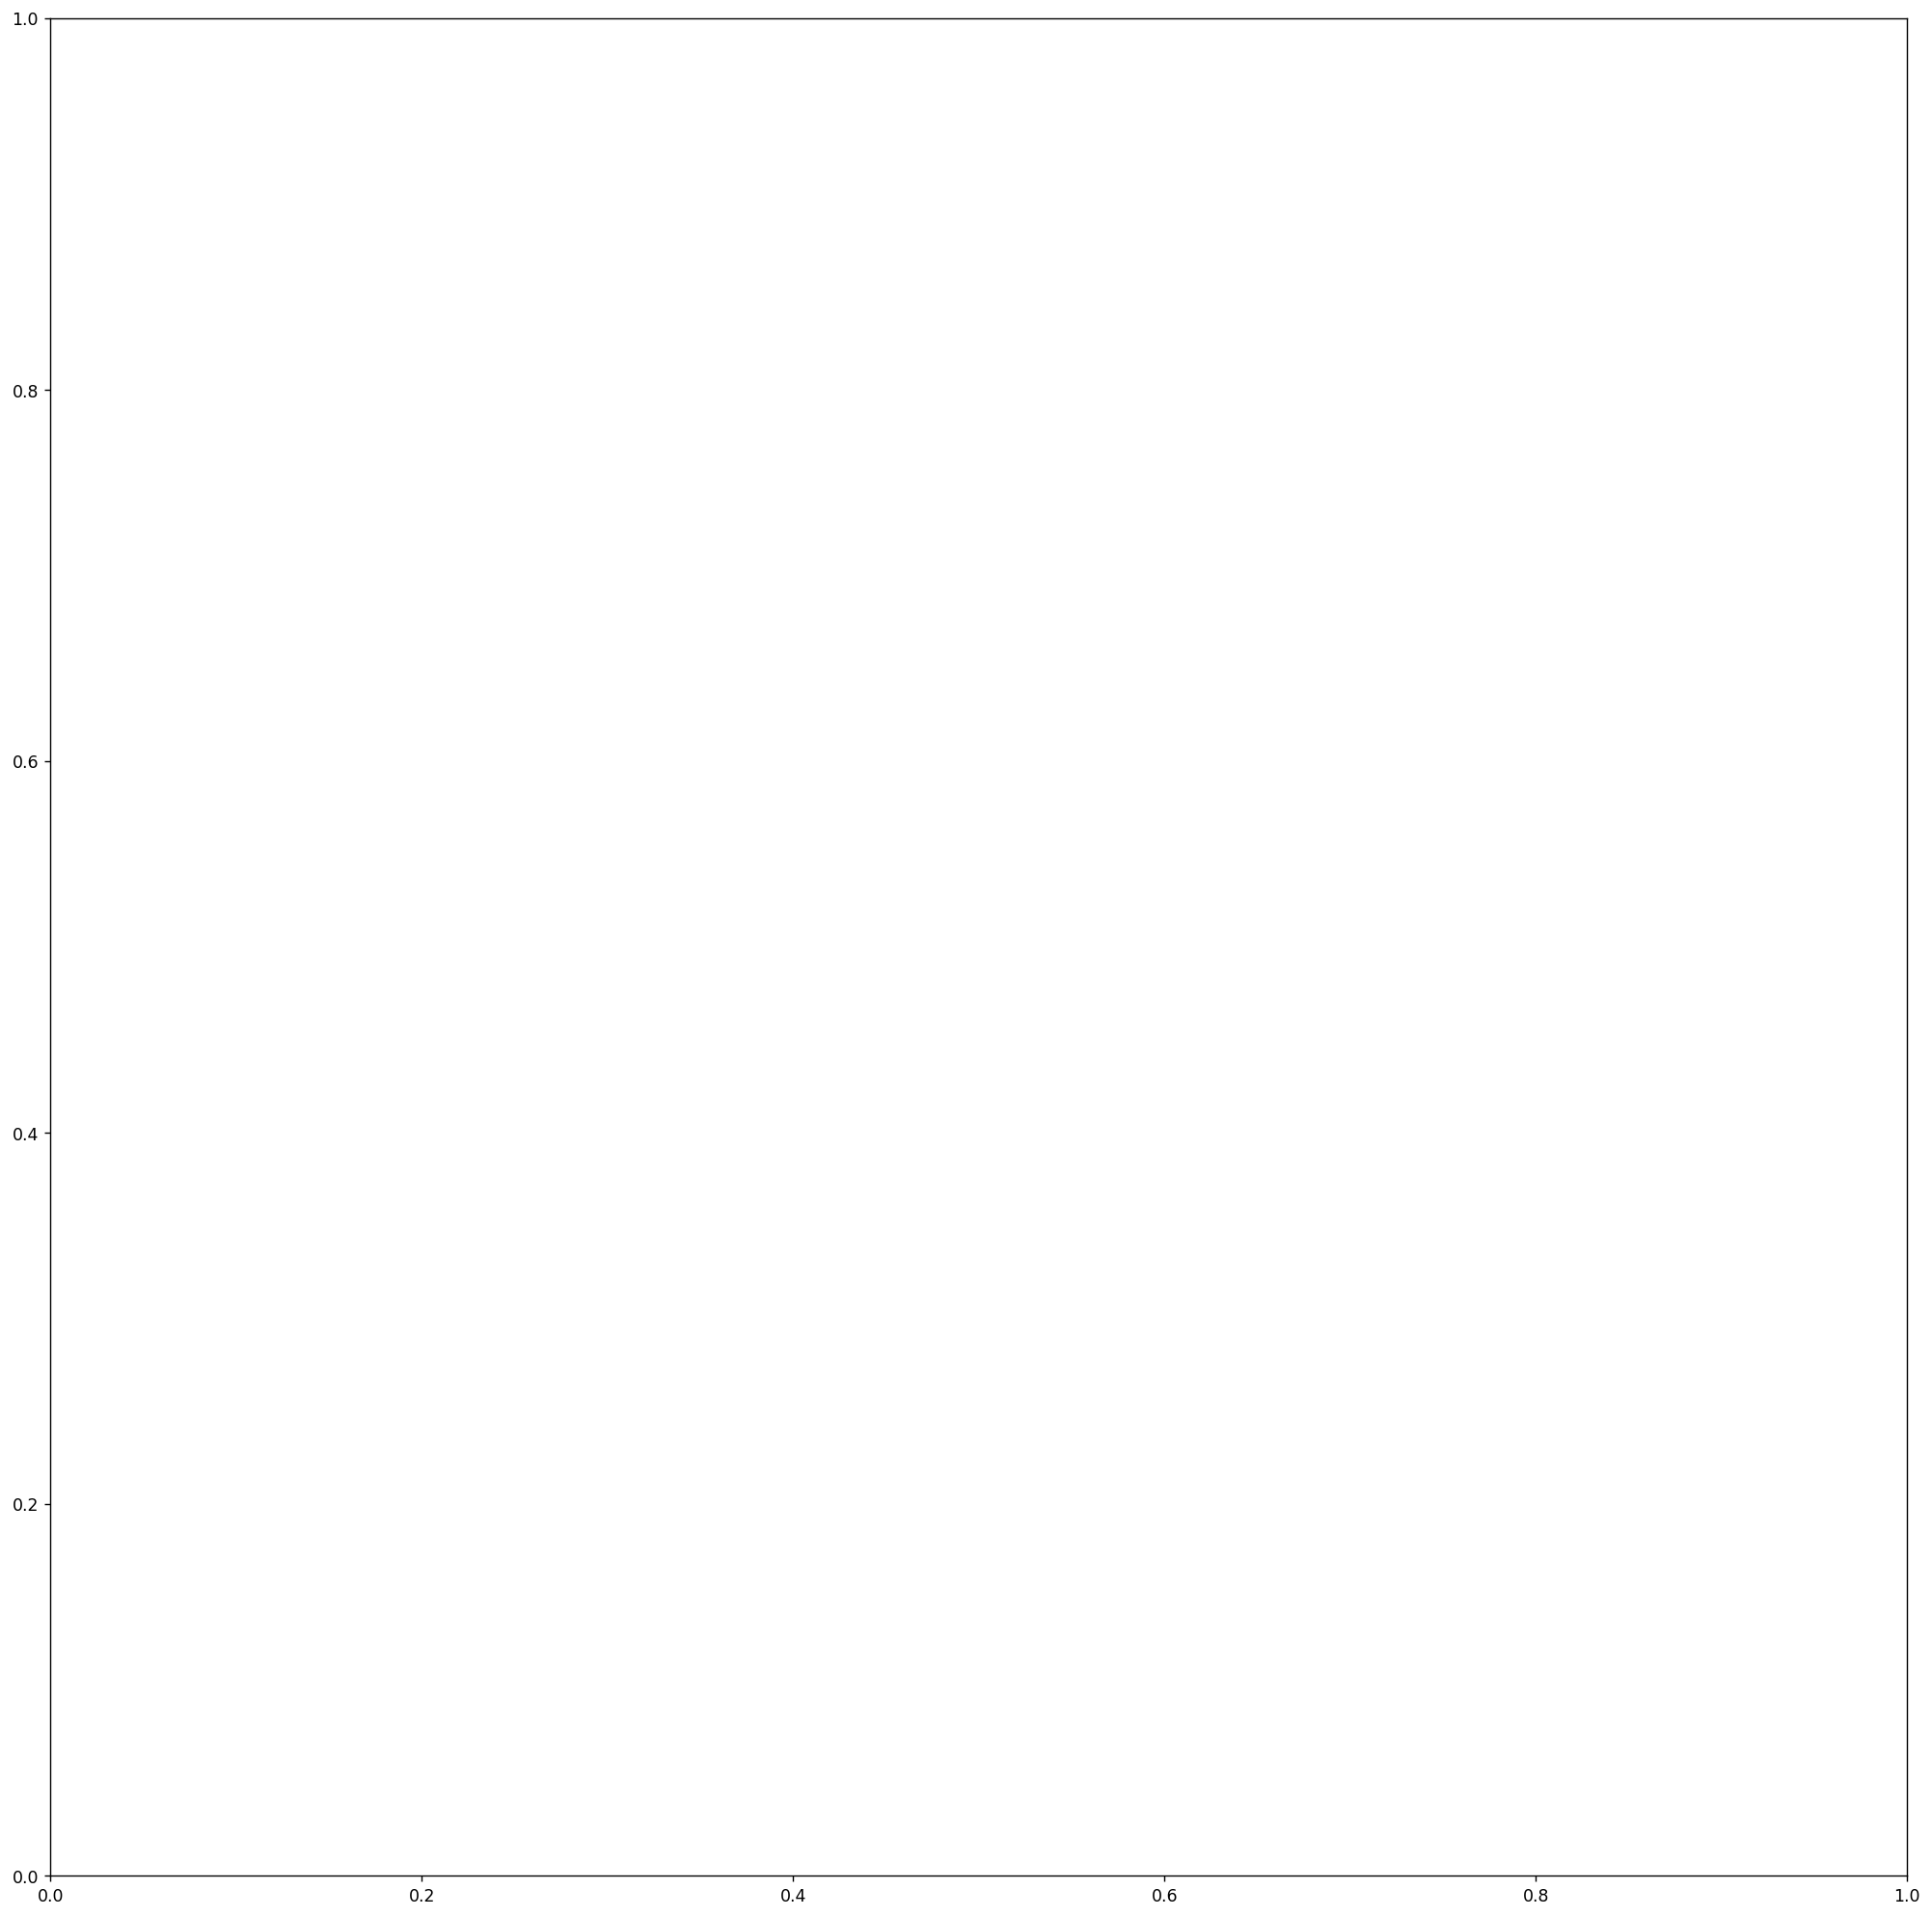

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=125, facecolor='white')

gpd.read_postgis("""
SELECT DISTINCT asbmb.area_sqkm, asbmb.geometry, asbmb.mb_cat
FROM gnaf.LOCALITY l
JOIN gnaf.ADDRESS_DETAIL ad
  ON ad.locality_pid = l.locality_pid
JOIN gnaf.STREET_LOCALITY sl 
  ON ad.street_locality_pid = sl.street_locality_pid
JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021
  ON ad.address_detail_pid = amb2021.address_detail_pid
JOIN gnaf.MB_2021 mb2021
  ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
JOIN abs_main_structures.Meshblock asbmb
  ON asbmb.mb_code = mb2021.mb_2021_code
JOIN gnaf.STATE s
  ON l.state_pid = s.state_pid
WHERE 
    s.state_abbreviation = 'NSW' AND
    l.locality_name IN %(locality_names)s
""", engine, params={
    'locality_names': ('BAULKHAM HILLS',)
}, geom_col='geometry').plot(
    ax=ax,
    column='mb_cat',
    legend=True,
    figsize=(10, 150),
    alpha=0.75
)



gpd.read_postgis("""
SELECT DISTINCT asbmb.area_sqkm, asbmb.geometry, asbmb.mb_cat
FROM gnaf.LOCALITY l
JOIN gnaf.ADDRESS_DETAIL ad
  ON ad.locality_pid = l.locality_pid
JOIN gnaf.STREET_LOCALITY sl 
  ON ad.street_locality_pid = sl.street_locality_pid
JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021
  ON ad.address_detail_pid = amb2021.address_detail_pid
JOIN gnaf.MB_2021 mb2021
  ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
JOIN abs_main_structures.Meshblock asbmb
  ON asbmb.mb_code = mb2021.mb_2021_code
JOIN gnaf.STATE s
  ON l.state_pid = s.state_pid
WHERE 
    s.state_abbreviation = 'NSW' AND
    sl.street_name IN %(street_names)s AND
    l.locality_name IN %(locality_names)s
""", engine, params={
    'street_names': ('TURON',),
    'locality_names': ('BAULKHAM HILLS',)
}, geom_col='geometry').plot(
    ax=ax,
    color='black',
    legend=True,
    figsize=(10, 150),
)

gpd.read_postgis("""
SELECT DISTINCT asbmb.area_sqkm, asbmb.geometry, asbmb.mb_cat
FROM gnaf.LOCALITY l
JOIN gnaf.ADDRESS_DETAIL ad
  ON ad.locality_pid = l.locality_pid
JOIN gnaf.STREET_LOCALITY sl 
  ON ad.street_locality_pid = sl.street_locality_pid
JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021
  ON ad.address_detail_pid = amb2021.address_detail_pid
JOIN gnaf.MB_2021 mb2021
  ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
JOIN abs_main_structures.Meshblock asbmb
  ON asbmb.mb_code = mb2021.mb_2021_code
JOIN gnaf.STATE s
  ON l.state_pid = s.state_pid
WHERE 
    s.state_abbreviation = 'NSW' AND
    ad.number_first = %(street_number)s AND
    sl.street_name IN %(street_names)s AND
    l.locality_name IN %(locality_names)s
""", engine, params={
    'street_number': 40,
    'street_names': ('TURON',),
    'locality_names': ('BAULKHAM HILLS',)
}, geom_col='geometry').plot(
    ax=ax,
    color='blue',
    legend=True,
    figsize=(10, 150),
)

In [7]:
import pandas as pd

engine = gnaf.engine()

df = pd.read_sql("""
SELECT 
    ad.address_detail_pid,
    ad.building_name,
    ad.lot_number,
    ad.street_locality_pid,
    sl.street_name,
    sl.street_type_code,
    sl.street_suffix_code,
    l.locality_name,
    l.primary_postcode,
    mb.mb_2021_code
FROM 
    gnaf.ADDRESS_DETAIL ad
JOIN 
    gnaf.ADDRESS_MESH_BLOCK_2021 amb ON ad.address_detail_pid = amb.address_detail_pid
JOIN 
    gnaf.MB_2021 mb ON amb.mb_2021_pid = mb.mb_2021_pid
JOIN 
    gnaf.STREET_LOCALITY sl ON ad.street_locality_pid = sl.street_locality_pid
JOIN 
    gnaf.LOCALITY l ON ad.locality_pid = l.locality_pid
WHERE 
    mb.mb_2021_code = '10000010000'
""", engine)
df.head()

,address_detail_pid,building_name,lot_number,street_locality_pid,street_name,street_type_code,street_suffix_code,locality_name,primary_postcode,mb_2021_code


In [8]:
import pandas as pd
lv_data = pd.read_csv('_out_zip/lv_20240701/001_LAND_VALUE_DATA_20240701.csv')
display(lv_data.head())

FileNotFoundError: [Errno 2] No such file or directory: '_out_zip/lv_20240701/001_LAND_VALUE_DATA_20240701.csv'

In [ ]:
import pandas as pd
from fuzzywuzzy import process

lv_data = pd.read_csv('_out_zip/lv_20240701/001_LAND_VALUE_DATA_20240701.csv')
lv_data = lv_data.rename(columns={
    'DISTRICT CODE': 'district_code',
    'DISTRICT NAME': 'district_name',
    'PROPERTY ID': 'property_id',
    'PROPERTY TYPE': 'property_type',
    'PROPERTY NAME': 'property_name',
    'UNIT NUMBER': 'unit_number',
    'HOUSE NUMBER': 'house_number',
    'STREET NAME': 'street_name_lv',
    'SUBURB NAME': 'suburb',
    'POSTCODE': 'postcode',
    'PROPERTY DESCRIPTION': 'property_description',
    'ZONE CODE': 'zone_code',
    'AREA': 'area',
    'AREA TYPE': 'area_type',
})

lv_data['postcode'] = [str(n) for n in lv_data['postcode']]

gnaf_names = pd.read_sql("""
SELECT DISTINCT 
    sl.street_locality_pid,
    sl.street_name,
    l.locality_name as suburb,
    ad.postcode

  FROM gnaf.ADDRESS_DETAIL ad
  JOIN gnaf.STREET_LOCALITY sl ON ad.street_locality_pid = sl.street_locality_pid
  JOIN gnaf.locality l ON sl.locality_pid = l.locality_pid
  JOIN gnaf.state s ON l.state_pid = s.state_pid
 
 WHERE l.locality_name IN %(locality_names)s
   AND ad.postcode IN %(post_codes)s
   AND s.state_abbreviation = 'NSW'
""", engine, params={
    'locality_names': tuple(lv_data['suburb'].unique()),
    'post_codes': tuple(lv_data['postcode'].unique()),
})


gnaf_names['postcode'] = [str(n) for n in gnaf_names['postcode']]


lv_data_unique = lv_data[~lv_data['street_name_lv'].isna()]
lv_data_unique = lv_data_unique[['street_name_lv', 'postcode', 'suburb']].drop_duplicates()

def fuzzy_match(row, choices, field):
    matches = process.extract(row[field], choices, limit=1)
    # print(matches, row[field], choices)
    if matches:
        return matches[0][0]
    return None

# Apply fuzzy matching for each unique street name in the land value data
matched_street_names = []
for _, row in lv_data_unique.iterrows():
    subset = gnaf_names[(gnaf_names['postcode'] == row['postcode']) & (gnaf_names['suburb'] == row['suburb'])]
    choices = subset['street_name'].tolist()
    match = fuzzy_match(row, choices, 'street_name_lv')
    matched_street_names.append(match)

lv_data_unique['street_name'] = matched_street_names
lv_data = lv_data.merge(lv_data_unique, how='left', on=['street_name_lv', 'postcode', 'suburb'])

display(lv_data.head())
display(lv_data['area_type'].unique())

unknown_street = lv_data[lv_data['street_name_lv'].isna()]

for i, row in unknown_street.iterrows():
    name = unknown_street.loc[i, 'property_name']
    desc = unknown_street.loc[i, 'property_description']
    print(name, desc)
    
# display(unknown_street[['property_name', 'property_description']].head())


gnaf_props = pd.read_sql("""
SELECT DISTINCT 
    ad.address_detail_pid,
    ad.building_name as property_name,
    sl.street_name,
    l.locality_name as suburb,
    ad.postcode
    -- ,  aas.address_site_name as property_name
  FROM gnaf.ADDRESS_DETAIL ad
  JOIN gnaf.LOCALITY l ON ad.locality_pid = l.locality_pid
  JOIN gnaf.STREET_LOCALITY sl ON ad.street_locality_pid = sl.street_locality_pid
  JOIN gnaf.STATE s ON l.state_pid = s.state_pid
  JOIN gnaf.ADDRESS_SITE aas ON ad.address_site_pid = aas.address_site_pid
 WHERE l.locality_name IN %(locality_names)s
   AND ad.postcode IN %(post_codes)s
   AND s.state_abbreviation = 'NSW'
   AND ad.building_name IS NOT NULL
   -- AND aas.address_site_name IS NOT NULL
   -- AND (ad.building_name IS NOT NULL OR aas.address_site_name IS NOT NULL)
""", engine, params={
    'locality_names': tuple(unknown_street['suburb'].unique()),
    'post_codes': tuple(unknown_street['postcode'].unique()),
})

# for _, row in unknown_street.iterrows():
#     subset = gnaf_props[(gnaf_props['postcode'] == row['postcode']) & (gnaf_props['suburb'] == row['suburb'])]
#     choices = subset['property_name'].tolist()
#     match = fuzzy_match(row, choices, 'property_name')
#     print(row['property_name'], match)

# display(gnaf_properties.head())



In [ ]:
import pandas as pd

# Load the land value data
lv_data = pd.read_csv('_out_zip/lv_20240701/001_LAND_VALUE_DATA_20240701.csv')
lv_data['POSTCODE'] = lv_data['POSTCODE'].astype(str)
lv_data['PROPERTY ID'] = lv_data['PROPERTY ID'].astype(str)

# Query the GNAF database to get the address details for the property IDs in the land value data
property_ids = tuple(lv_data['PROPERTY ID'].unique())

gnaf_addresses = pd.read_sql("""
SELECT DISTINCT 
    ad.address_detail_pid,
    ad.building_name,
    ad.lot_number,
    ad.flat_type_code,
    ad.flat_number,
    ad.level_type_code,
    ad.level_number,
    ad.number_first,
    ad.number_last,
    sl.street_name,
    l.locality_name AS suburb,
    ad.postcode,
    ad.property_pid,
    ad.gnaf_property_pid
  FROM gnaf.ADDRESS_DETAIL ad
  JOIN gnaf.STREET_LOCALITY sl ON ad.street_locality_pid = sl.street_locality_pid
  JOIN gnaf.locality l ON ad.locality_pid = l.locality_pid
  JOIN gnaf.state s ON l.state_pid = s.state_pid
 WHERE l.locality_name IN %(locality_names)s
   AND ad.postcode IN %(post_codes)s
   AND s.state_abbreviation = 'NSW'
""", engine, params={
    'locality_names': tuple(lv_data['SUBURB NAME'].unique()),
    'post_codes': tuple(lv_data['POSTCODE'].unique()),
})


# Ensure postcodes are treated as strings
gnaf_addresses['postcode'] = gnaf_addresses['postcode'].astype(str)

# Merge the land value data with the GNAF addresses based on property_id
merged_data = pd.merge(lv_data, gnaf_addresses, how='left', left_on='PROPERTY ID', right_on='property_pid')

display(gnaf_addresses.head())
# Display results
print("Merged Data:")
display(merged_data.head())

# Identify rows that failed to match
failed_matches = merged_data[merged_data['street_name'].isnull()]

# Display debug information
print(f"Total rows in land value data: {len(lv_data)}")
print(f"Total matched rows: {len(merged_data) - len(failed_matches)}")
print(f"Total failed matches: {len(failed_matches)}")

# Display failed matches for inspection
print("Failed Matches:")
display(failed_matches)


In [ ]:
lot_numbers = pd.read_sql("""
  SELECT
      ad.address_detail_pid as id,
      ad.legal_parcel_id,
      ad.building_name as name,
      CONCAT(ad.lot_number_prefix, ad.lot_number, ad.lot_number_suffix) as lot,
      CONCAT(ad.flat_number_prefix, ad.flat_number, ad.flat_number_suffix) as unit,
      CONCAT(COALESCE(ad.level_type_code || ' ', ''),
             COALESCE(ad.level_number_prefix || '-', ''),
             ad.level_number,
             COALESCE('-' || ad.level_number_suffix, '')) as level,
      CONCAT(
        ad.number_first_prefix, ad.number_first, ad.number_first_suffix,
        COALESCE('-' || ad.number_last_prefix || ad.number_last || ad.number_last_suffix, '')
      ) as house,
      sl.street_name,
      l.locality_name,
      ad.postcode
    FROM gnaf.ADDRESS_DETAIL ad
    JOIN gnaf.LOCALITY l ON ad.locality_pid = l.locality_pid
    JOIN gnaf.STREET_LOCALITY sl ON ad.street_locality_pid = sl.street_locality_pid
    JOIN gnaf.STATE s ON l.state_pid = s.state_pid
   WHERE s.state_abbreviation = 'NSW'
     AND ad.legal_parcel_id = '1000/1097758'
   ORDER BY street_name, house, level, unit
  OFFSET 0
""", gnaf.engine())
lot_numbers

In [ ]:
from sqlalchemy import text

bh_df = gpd.read_postgis(text("""
    SELECT gcc.*
     FROM abs_main_structures.gccsa gcc
"""), gnaf.engine(), geom_col='geometry')
bh_df.head()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text

df = gpd.read_postgis(text("""
    SELECT DISTINCT ON (asbmb.mb_code)
           pd.property_description,
           p.property_name,
           p.property_id, 
           p.zone_code as zone,
           p.area,
           v.land_value,
           CASE
             WHEN p.area IS NULL THEN 1
             ELSE v.land_value
           END / CASE
             WHEN p.property_id IN :should_be_hectares THEN p.area * 10000
             WHEN p.area IS NULL THEN 1
             WHEN p.area < 10 THEN 10
             WHEN p.area < 50 THEN 50.0
             WHEN p.area < 100 THEN 100.0
             ELSE p.area
           END as per_m2,
           v.base_date,
           p.unit_number as unit,
           p.house_number as house,
           st.street_name as street,
           su.suburb_name as suburb,
           p.postcode,
           lp.land_parcel_id,
           asbmb.geometry
           
      FROM nsw_valuer_general.property p
     
      LEFT JOIN (SELECT DISTINCT ON (property_id) * FROM nsw_valuer_general.valuations
                  ORDER BY property_id, base_date DESC) v ON p.property_id = v.property_id
             
      LEFT JOIN (SELECT * FROM nsw_valuer_general.land_parcel_link
                  ORDER BY property_id, part DESC) lp ON p.property_id = lp.property_id
      
      LEFT JOIN nsw_valuer_general.street st ON p.street_id = st.street_id
      LEFT JOIN nsw_valuer_general.suburb su ON p.suburb_id = su.suburb_id
      LEFT JOIN nsw_valuer_general.property_description pd ON pd.property_id = p.property_id
      LEFT JOIN gnaf.ADDRESS_DETAIL ad ON lp.land_parcel_id = ad.legal_parcel_id
      LEFT JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021 ON ad.address_detail_pid = amb2021.address_detail_pid
      LEFT JOIN gnaf.MB_2021 mb2021 ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
      LEFT JOIN abs_main_structures.Meshblock asbmb ON asbmb.mb_code = mb2021.mb_2021_code
      LEFT JOIN non_abs_main_structures.lga_2024 lga ON ST_Intersects(asbmb.geometry, lga.geometry)
     
     WHERE lga.lga_name = :lga_name
     ORDER BY asbmb.mb_code, per_m2 DESC
"""), engine, params={
    'lga_name': 'Sydney',
    'should_be_hectares': should_be_hectares,
}, geom_col='geometry')

display(df.sort_values(by='per_m2', ascending=False).head())

display(pd.read_sql("""
    SELECT re.area, re.area_type, *
      FROM nsw_valuer_general.raw_entries re
     WHERE re.property_id = '2109562'
""", engine))

df.plot(
    column='per_m2',
    figsize=(20, 300),
)

In [ ]:

df = pd.read_sql("""
    SELECT ad.*
      FROM gnaf.ADDRESS_DETAIL ad
      LEFT JOIN gnaf.ADDRESS_SITE ass ON ad.address_site_pid = ass.address_site_pid
      LEFT JOIN gnaf.ADDRESS_DEFAULT_GEOCODE adg ON ad.address_detail_pid = adg.address_detail_pid
      LEFT JOIN gnaf.ADDRESS_SITE_GEOCODE asg ON asg.address_site_pid = ass.address_site_pid
     WHERE ad.legal_parcel_id = '11/813585'
""", engine)

for c in df.columns:
    display(f"{c}: {df.loc[0, c]}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text

df = pd.read_sql(text("""
     SELECT DISTINCT ON (property_id) * FROM nsw_valuer_general.valuations
      ORDER BY property_id DESC, base_date DESC
     LIMIT 25
"""), engine, params={
    'lga_name': 'Sydney',
})
df

In [ ]:

pd.read_sql(text("""
       SELECT lga.lga_name
         FROM non_abs_main_structures.lga_2024 lga
        WHERE lga.lga_name ILIKE :lga_name
"""), engine, params={
    'lga_name': '%Campbell%',
})

In [ ]:
import fiona

f = '_out_zip/non_abs_structures_shapefiles/ASGS_Ed3_Non_ABS_Structures_GDA2020_updated_2024.gpkg'
display(fiona.listlayers(f))
df = gpd.read_file(f, layer='DZN_2021_AUST_GDA2020')
display(df.columns)
display(df.head())

In [ ]:
import pandas as pd

df = pd.read_sql("""
SELECT DISTINCT *
  FROM abs_main_structures.state s
""", engine)
display(df)

df = pd.read_sql("""
SELECT DISTINCT st.street_name, p.postcode
  FROM nsw_valuer_general.property p
  LEFT JOIN nsw_valuer_general.suburb su ON p.suburb_id = su.suburb_id
  LEFT JOIN nsw_valuer_general.street st ON p.street_id = st.street_id
 WHERE su.suburb_name = 'ADAMINABY'
 LIMIT 5
""", engine)
display(df)

df = pd.read_sql("""
SELECT DISTINCT
    sl.street_locality_pid,
    l.locality_pid,
    sl.street_name || COALESCE(' ' || sta_1.name, '') || COALESCE(' ' || ssa_1.name, '') as street_name,
    asl.street_name || COALESCE(' ' || sta_2.name, '') || COALESCE(' ' || ssa_2.name, '')  as street_name_alias,
    sl.street_class_code,
    sl.date_retired,
    sl.date_created,
    sl.street_suffix_code,
    ad.postcode
  FROM gnaf.ADDRESS_DETAIL ad
  LEFT JOIN gnaf.locality l ON ad.locality_pid = l.locality_pid
  LEFT JOIN gnaf.STREET_LOCALITY sl ON sl.street_locality_pid = ad.street_locality_pid
  LEFT JOIN gnaf.STREET_LOCALITY_ALIAS asl ON sl.street_locality_pid = asl.street_locality_pid
  LEFT JOIN gnaf.STATE s ON l.state_pid = s.state_pid
  LEFT JOIN gnaf.STREET_TYPE_AUT sta_1 ON sta_1.code = sl.street_type_code
  LEFT JOIN gnaf.STREET_TYPE_AUT sta_2 ON sta_2.code = asl.street_type_code
  LEFT JOIN gnaf.STREET_SUFFIX_AUT ssa_1 ON ssa_1.code = sl.street_suffix_code
  LEFT JOIN gnaf.STREET_SUFFIX_AUT ssa_2 ON ssa_2.code = asl.street_suffix_code
 WHERE 
    sl.street_locality_pid IN ('NSW2575294', 'NSW2575296')
""", engine)
display(df)

In [ ]:
import fiona

# Path to your GeoPackage file
file = '_out_zip/non_abs_structures_shapefiles/ASGS_Ed3_Non_ABS_Structures_GDA2020_updated_2024.gpkg'
layers = ['SAL_2021_AUST_GDA2020', 'ADD_2021_AUST_GDA2020', 'TR_2021_AUST_GDA2020', 'SED_2021_AUST_GDA2020', 'CED_2021_AUST_GDA2020', 'LGA_2021_AUST_GDA2020', 'SED_2022_AUST_GDA2020', 'DZN_2021_AUST_GDA2020', 'LGA_2022_AUST_GDA2020', 'POA_2021_AUST_GDA2020', 'LGA_2023_AUST_GDA2020', 'SED_2024_AUST_GDA2020', 'LGA_2024_AUST_GDA2020']

df = gpd.read_file(file, layer='POA_2021_AUST_GDA2020')
display(df.info())
df['POA_CODE_2021'].str.len().max()


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text

should_be_hectares = (
    # Public schools
    '2109562',
    '3045369',
    
    # Hospitial
    '1915895',

    # Random houses
    '2013895', # 301/807604, 3.507sqm, (a house)
    '2007459', # 286/230712, 8.230sqm, (a house)
    '1976991', # 3/34169, 22.3sqm, (a house)
    '1984039', # 4/6700, 46.8sqm, (a house)
    
    # Unsure what happened here
    '4062073',
    '3803977',
    '1935693',
    '1986173', # 1063/752015, 2.116sqm, (a field)
    '1390065', # 130/1007385, 15.3sqm
)

bh_df = gpd.read_postgis(text("""
  WITH lga_mb AS (
       SELECT asbmb.*
         FROM abs_main_structures.Meshblock asbmb
         LEFT JOIN non_abs_main_structures.lga_2024 lga ON ST_Intersects(asbmb.geometry, lga.geometry)
        WHERE lga.lga_name IN :lga_names
          AND (ST_Area(ST_Intersection(asbmb.geometry, lga.geometry)) / ST_Area(asbmb.geometry)) > 0.5
  ), 
  
  p_in_lga AS (
       SELECT DISTINCT ON (p.property_id, lp.land_parcel_id) p.*, asbmb.*, lp.land_parcel_id
         FROM nsw_valuer_general.property p
         LEFT JOIN nsw_valuer_general.land_parcel_link lp ON p.property_id = lp.property_id
         LEFT JOIN gnaf.ADDRESS_DETAIL ad ON lp.land_parcel_id = ad.legal_parcel_id
         LEFT JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021 ON ad.address_detail_pid = amb2021.address_detail_pid
         LEFT JOIN gnaf.MB_2021 mb2021 ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
        INNER JOIN lga_mb asbmb ON asbmb.mb_code = mb2021.mb_2021_code
        ORDER BY p.property_id, lp.land_parcel_id
  ),
  
  p_square_area_value AS (
       SELECT DISTINCT ON (p.property_id, p.land_parcel_id)
              p.property_id,
              p.land_parcel_id,
              p.mb_code,
              v.land_value,
              CASE
                WHEN p.area IS NULL THEN 1
                ELSE v.land_value
              END / CASE
                WHEN p.property_id IN :should_be_hectares THEN p.area * 10000
                WHEN p.area IS NULL THEN 1
                WHEN p.area < 10 THEN 10
                -- WHEN p.area < 50 THEN 50.0
                -- WHEN p.area < 100 THEN 100.0
                ELSE p.area
              END as per_m2
         FROM p_in_lga p
         LEFT JOIN (
           SELECT DISTINCT ON (property_id) * FROM nsw_valuer_general.valuations
            ORDER BY property_id, base_date DESC) v 
           ON p.property_id = v.property_id
        ORDER BY p.property_id, p.land_parcel_id
  ),
  
  p_square_area_p95 AS (
      SELECT p.mb_code, PERCENTILE_CONT(:percentile) WITHIN GROUP (ORDER BY per_m2) AS per_m2_p95
        FROM p_square_area_value p GROUP BY p.mb_code
  )
  
    SELECT DISTINCT ON (p.property_id) 
           pd.property_description,
           pv.land_parcel_id,
           p.property_name,
           p.property_id, 
           p.zone_code,
           log(pv.land_value) * (1 - :log_scaling) + (pv.land_value * :log_scaling) as rank,
           pv.per_m2 as per_m2,
           pv.land_value,
           p.area,
           p.property_name as name,
           p.unit_number as unit,
           p.house_number as house,
           st.street_name as street,
           su.suburb_name as suburb,
           p.postcode,
           mb.geometry
      FROM nsw_valuer_general.property p
      LEFT JOIN nsw_valuer_general.property_description pd ON pd.property_id = p.property_id
     RIGHT JOIN p_square_area_value pv ON pv.property_id = p.property_id
     INNER JOIN p_square_area_p95 p95 ON p95.mb_code = pv.mb_code
     INNER JOIN lga_mb mb ON mb.mb_code = pv.mb_code
      LEFT JOIN nsw_valuer_general.street st ON p.street_id = st.street_id
      LEFT JOIN nsw_valuer_general.suburb su ON p.suburb_id = su.suburb_id
     WHERE pv.per_m2 IS NOT NULL
       AND p.zone_code IN :zone_codes
     ORDER BY p.property_id, pv.per_m2 -- , (p95.per_m2_p95 - pv.per_m2)
"""), engine, params={
    'should_be_hectares': should_be_hectares,
    'zone_codes': ('R2',),
    'lga_names': (
        # 'Sydney',
        # 'Inner West',
        # 'Canada Bay',
        # 'Burwood',
        'Strathfield',
        # 'Randwick',
        # 'Woollahra',
        # 'Waverley',
        # 'Bayside (NSW)',
        # 'Georges River',
        # 'Sutherland',
        # 'Canterbury-Bankstown',
        # 'Parramatta',
        # 'Cumberland',
        # 'Ryde',
        # 'Lane Cove',
        # 'Hunters Hill',
        # 'Willoughby',
        # 'Mosman',
        # 'North Sydney',
        # 'Ku-ring-gai',
        # 'Northern Beaches',
        # 'Hornsby',
        # 'The Hills', 
        # 'Blacktown',
        # 'Liverpool',
        # 'Penrith', 
        # 'Campbelltown (NSW)',
        # 'Camden',
    ),
    'percentile': 0.75,
    'log_scaling': 0.75,
}, geom_col='geometry')


# 'Sydney', 'Inner West', 'Canada Bay',
# 'Burwood', 'Strathfield', 'Randwick',
# 'Woollahra', 'Waverley', 'Bayside (NSW)',
# 'Georges River', 'Canterbury-Bankstown',
# 'Parramatta',  'Cumberland', 'Ryde',
# 'Lane Cove', 'Hunters Hill', 'Willoughby',
# 'Mosman', 'North Sydney', 'Ku-ring-gai', 'Fairfield', 
# 'Northern Beaches', 'The Hills', 'Hornsby', 
# 'Blacktown', 'Liverpool', 'Penrith', 
# 'Sutherland', 'Campbelltown (NSW)', 'Camden',

display(bh_df.sort_values(by='land_value', ascending=False).iloc[5:15,:])

bh_df.plot(
    column='rank',
    figsize=(20, 20),
)


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text

should_be_hectares = (
    # schools
    '2109562',
    '3045369',
    
    # Hospitial
    '1915895',

    # Random houses
    '2013895', # 301/807604, 3.507sqm, (a house)
    '2007459', # 286/230712, 8.230sqm, (a house)
    '1976991', # 3/34169, 22.3sqm, (a house)
    '1984039', # 4/6700, 46.8sqm, (a house)
    
    # Unsure what happened here
    '4062073',
    '3803977',
    '1935693',
    '1986173', # 1063/752015, 2.116sqm, (a field)
    '1390065', # 130/1007385, 15.3sqm
    '2430736', # 2/877672, < 3sqm
)

bh_df = gpd.read_postgis(text("""
  WITH lga_mb AS (
       SELECT asbmb.*
         FROM abs_main_structures.Meshblock asbmb
         LEFT JOIN non_abs_main_structures.lga_2024 lga ON ST_Intersects(asbmb.geometry, lga.geometry)
        WHERE lga.lga_name IN :lga_names
          AND (ST_Area(ST_Intersection(asbmb.geometry, lga.geometry)) / ST_Area(asbmb.geometry)) > 0.5
  ), 
  
  p_in_lga AS (
       SELECT DISTINCT ON (p.property_id, lp.land_parcel_id) p.*, asbmb.*, lp.land_parcel_id
         FROM nsw_valuer_general.property p
         LEFT JOIN nsw_valuer_general.land_parcel_link lp ON p.property_id = lp.property_id
         LEFT JOIN gnaf.ADDRESS_DETAIL ad ON lp.land_parcel_id = ad.legal_parcel_id
         LEFT JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021 ON ad.address_detail_pid = amb2021.address_detail_pid
         LEFT JOIN gnaf.MB_2021 mb2021 ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
        INNER JOIN lga_mb asbmb ON asbmb.mb_code = mb2021.mb_2021_code
        ORDER BY p.property_id, lp.land_parcel_id
  ),
  
  p_square_area_value AS (
       SELECT DISTINCT ON (p.property_id, p.land_parcel_id)
              p.property_id,
              p.land_parcel_id,
              p.mb_code,
              v.land_value,
              CASE
                WHEN p.area IS NULL THEN 1
                ELSE v.land_value
              END / CASE
                WHEN p.property_id IN :should_be_hectares THEN p.area * 10000
                WHEN p.area IS NULL THEN 1
                WHEN p.area < 10 THEN 10
                -- WHEN p.area < 50 THEN 50.0
                -- WHEN p.area < 100 THEN 100.0
                ELSE p.area
              END as per_m2
         FROM p_in_lga p
         LEFT JOIN (
           SELECT DISTINCT ON (property_id) * FROM nsw_valuer_general.valuations
            ORDER BY property_id, base_date DESC) v 
           ON p.property_id = v.property_id
        ORDER BY p.property_id, p.land_parcel_id
  ),
  
  p_square_area_p95 AS (
      SELECT p.mb_code, PERCENTILE_CONT(:percentile) WITHIN GROUP (ORDER BY per_m2) AS per_m2_p95
        FROM p_square_area_value p GROUP BY p.mb_code
  )
  
    SELECT DISTINCT ON (mb.mb_code) 
           pd.property_description,
           pv.land_parcel_id,
           p.property_name,
           p.property_id, 
           p.zone_code,
           log(pv.land_value) * (1 - :log_scaling) + (pv.land_value * :log_scaling) as rank,
           pv.per_m2 as per_m2,
           pv.land_value,
           p.area,
           p.property_name as name,
           p.unit_number as unit,
           p.house_number as house,
           st.street_name as street,
           su.suburb_name as suburb,
           p.postcode,
           mb.geometry
      FROM nsw_valuer_general.property p
      LEFT JOIN nsw_valuer_general.property_description pd ON pd.property_id = p.property_id
     RIGHT JOIN p_square_area_value pv ON pv.property_id = p.property_id
     INNER JOIN p_square_area_p95 p95 ON p95.mb_code = pv.mb_code
     INNER JOIN lga_mb mb ON mb.mb_code = pv.mb_code
      LEFT JOIN nsw_valuer_general.street st ON p.street_id = st.street_id
      LEFT JOIN nsw_valuer_general.suburb su ON p.suburb_id = su.suburb_id
     WHERE pv.per_m2 IS NOT NULL
     ORDER BY mb.mb_code,  (p95.per_m2_p95 - pv.per_m2)
"""), engine, params={
    'should_be_hectares': should_be_hectares,
    'lga_names': (
        'Sydney',
        # 'Inner West',
        # 'Canada Bay',
        # 'Burwood',
        # 'Strathfield',
        # 'Randwick',
        # 'Woollahra',
        # 'Waverley',
        # 'Bayside (NSW)',
        # 'Georges River',
        # 'Sutherland',
        # 'Canterbury-Bankstown',
        # 'Parramatta',
        # 'Cumberland',
        # 'Ryde',
        # 'Lane Cove',
        # 'Hunters Hill',
        # 'Willoughby',
        # 'Mosman',
        # 'North Sydney',
        # 'Ku-ring-gai',
        # 'Fairfield', 
        # 'Northern Beaches',
        # 'Hornsby',
        # 'The Hills', 
        # 'Blacktown',
        # 'Liverpool',
        # 'Penrith', 
        # 'Campbelltown (NSW)',
        # 'Camden',
    ),
    'percentile': 1,
    'log_scaling': 0.75,
}, geom_col='geometry')



display(bh_df.sort_values(by='per_m2', ascending=False).iloc[5:15,:])

# 'Sydney', 'Inner West', 'Canada Bay',
# 'Burwood', 'Strathfield', 'Randwick',
# 'Woollahra', 'Waverley', 'Bayside (NSW)',
# 'Georges River', 'Canterbury-Bankstown',
# 'Parramatta',  'Cumberland', 'Ryde',
# 'Lane Cove', 'Hunters Hill', 'Willoughby',
# 'Mosman', 'North Sydney', 'Ku-ring-gai', 'Fairfield', 
# 'Northern Beaches', 'The Hills', 'Hornsby', 
# 'Blacktown', 'Liverpool', 'Penrith', 
# 'Sutherland', 'Campbelltown (NSW)', 'Camden',

bh_df.plot(
    column='per_m2',
    figsize=(20, 20),
)


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text

should_be_hectares = (
    # schools
    '2109562',
    '3045369',
    
    # Hospitial
    '1915895',

    # Random houses
    '2013895', # 301/807604, 3.507sqm, (a house)
    '2007459', # 286/230712, 8.230sqm, (a house)
    '1976991', # 3/34169, 22.3sqm, (a house)
    '1984039', # 4/6700, 46.8sqm, (a house)
    
    # Unsure what happened here
    '4062073',
    '3803977',
    '1935693',
    '1986173', # 1063/752015, 2.116sqm, (a field)
    '1390065', # 130/1007385, 15.3sqm
    '2430736', # 2/877672, < 3sqm
)

bh_df = gpd.read_postgis(text("""
  WITH lga_mb AS (
       SELECT asbmb.*
         FROM abs_main_structures.Meshblock asbmb
         LEFT JOIN non_abs_main_structures.lga_2024 lga ON ST_Intersects(asbmb.geometry, lga.geometry)
        WHERE lga.lga_name IN :lga_names
          AND (ST_Area(ST_Intersection(asbmb.geometry, lga.geometry)) / ST_Area(asbmb.geometry)) > 0.5
  ), 
  
  p_in_lga AS (
       SELECT DISTINCT ON (p.property_id, lp.land_parcel_id) p.*, asbmb.*, lp.land_parcel_id
         FROM nsw_valuer_general.property p
         LEFT JOIN nsw_valuer_general.land_parcel_link lp ON p.property_id = lp.property_id
         LEFT JOIN gnaf.ADDRESS_DETAIL ad ON lp.land_parcel_id = ad.legal_parcel_id
         LEFT JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021 ON ad.address_detail_pid = amb2021.address_detail_pid
         LEFT JOIN gnaf.MB_2021 mb2021 ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
        INNER JOIN lga_mb asbmb ON asbmb.mb_code = mb2021.mb_2021_code
        ORDER BY p.property_id, lp.land_parcel_id
  ),
  
  p_square_area_value AS (
       SELECT DISTINCT ON (p.property_id, p.land_parcel_id)
              p.property_id,
              p.land_parcel_id,
              p.mb_code,
              v.land_value,
              CASE
                WHEN p.area IS NULL THEN 1
                ELSE v.land_value
              END / CASE
                WHEN p.property_id IN :should_be_hectares THEN p.area * 10000
                WHEN p.area IS NULL THEN 1
                WHEN p.area < 10 THEN 10
                -- WHEN p.area < 50 THEN 50.0
                -- WHEN p.area < 100 THEN 100.0
                ELSE p.area
              END as per_m2
         FROM p_in_lga p
         LEFT JOIN (
           SELECT DISTINCT ON (property_id) * FROM nsw_valuer_general.valuations
            ORDER BY property_id, base_date DESC) v 
           ON p.property_id = v.property_id
        ORDER BY p.property_id, p.land_parcel_id
  ),
  
  p_square_area_p95 AS (
      SELECT p.mb_code, PERCENTILE_CONT(:percentile) WITHIN GROUP (ORDER BY per_m2) AS per_m2_p95
        FROM p_square_area_value p GROUP BY p.mb_code
  )
  
    SELECT DISTINCT ON (mb.mb_code) 
           pd.property_description,
           pv.land_parcel_id,
           p.property_name,
           p.property_id, 
           p.zone_code,
           log(pv.land_value) * (1 - :log_scaling) + (pv.land_value * :log_scaling) as rank,
           pv.per_m2 as per_m2,
           pv.land_value,
           p.area,
           p.property_name as name,
           p.unit_number as unit,
           p.house_number as house,
           st.street_name as street,
           su.suburb_name as suburb,
           p.postcode,
           mb.geometry
      FROM nsw_valuer_general.property p
      LEFT JOIN nsw_valuer_general.property_description pd ON pd.property_id = p.property_id
     RIGHT JOIN p_square_area_value pv ON pv.property_id = p.property_id
     INNER JOIN p_square_area_p95 p95 ON p95.mb_code = pv.mb_code
     INNER JOIN lga_mb mb ON mb.mb_code = pv.mb_code
      LEFT JOIN nsw_valuer_general.street st ON p.street_id = st.street_id
      LEFT JOIN nsw_valuer_general.suburb su ON p.suburb_id = su.suburb_id
     WHERE pv.per_m2 IS NOT NULL
     ORDER BY mb.mb_code,  (p95.per_m2_p95 - pv.per_m2)
"""), engine, params={
    'should_be_hectares': should_be_hectares,
    'lga_names': ('Sydney',),
    'percentile': 1,
    'log_scaling': 1,
}, geom_col='geometry')

display(bh_df.sort_values(by='per_m2', ascending=False).iloc[5:15,:])

bh_df.plot(
    column='per_m2',
    figsize=(20, 20),
)


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text

should_be_hectares = (
    # schools
    '2109562',
    '3045369',
    
    # Hospitial
    '1915895',

    # Random houses
    '2013895', # 301/807604, 3.507sqm, (a house)
    '2007459', # 286/230712, 8.230sqm, (a house)
    '1976991', # 3/34169, 22.3sqm, (a house)
    '1984039', # 4/6700, 46.8sqm, (a house)
    
    # Unsure what happened here
    '4062073',
    '3803977',
    '1935693',
    '1986173', # 1063/752015, 2.116sqm, (a field)
    '1390065', # 130/1007385, 15.3sqm
    '2430736', # 2/877672, < 3sqm
)

bh_df = gpd.read_postgis(text("""
  WITH lga_mb AS (
       SELECT asbmb.*
         FROM abs_main_structures.Meshblock asbmb
         LEFT JOIN non_abs_main_structures.lga_2024 lga ON ST_Intersects(asbmb.geometry, lga.geometry)
        WHERE lga.lga_name IN :lga_names
          AND (ST_Area(ST_Intersection(asbmb.geometry, lga.geometry)) / ST_Area(asbmb.geometry)) > 0.5
  ), 
  
  p_in_lga AS (
       SELECT DISTINCT ON (p.property_id, lp.land_parcel_id) p.*, asbmb.*, lp.land_parcel_id
         FROM nsw_valuer_general.property p
         LEFT JOIN nsw_valuer_general.land_parcel_link lp ON p.property_id = lp.property_id
         LEFT JOIN gnaf.ADDRESS_DETAIL ad ON lp.land_parcel_id = ad.legal_parcel_id
         LEFT JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021 ON ad.address_detail_pid = amb2021.address_detail_pid
         LEFT JOIN gnaf.MB_2021 mb2021 ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
        INNER JOIN lga_mb asbmb ON asbmb.mb_code = mb2021.mb_2021_code
        ORDER BY p.property_id, lp.land_parcel_id
  ),
  
  p_square_area_value AS (
       SELECT DISTINCT ON (p.property_id, p.land_parcel_id)
              p.property_id,
              p.land_parcel_id,
              p.mb_code,
              v.land_value,
              CASE
                WHEN p.area IS NULL THEN 1
                ELSE v.land_value
              END / CASE
                -- WHEN p.property_id IN :should_be_hectares THEN p.area * 10000
                WHEN p.area IS NULL THEN 1
                ELSE p.area
              END as per_m2
         FROM p_in_lga p
         LEFT JOIN (
           SELECT DISTINCT ON (property_id) * FROM nsw_valuer_general.valuations
            ORDER BY property_id, base_date DESC) v 
           ON p.property_id = v.property_id
        ORDER BY p.property_id, p.land_parcel_id
  ),
  
  p_square_area_p95 AS (
      SELECT p.mb_code, PERCENTILE_CONT(:percentile) WITHIN GROUP (ORDER BY per_m2) AS per_m2_p95
        FROM p_square_area_value p GROUP BY p.mb_code
  )
  
    SELECT DISTINCT ON (mb.mb_code) 
           pd.property_description,
           pv.land_parcel_id,
           p.property_name,
           p.property_id, 
           p.zone_code,
           log(pv.land_value) * (1 - :log_scaling) + (pv.land_value * :log_scaling) as rank,
           pv.per_m2 as per_m2,
           pv.land_value,
           p.area,
           p.property_name as name,
           p.unit_number as unit,
           p.house_number as house,
           st.street_name as street,
           su.suburb_name as suburb,
           p.postcode,
           mb.geometry
      FROM nsw_valuer_general.property p
      LEFT JOIN nsw_valuer_general.property_description pd ON pd.property_id = p.property_id
     RIGHT JOIN p_square_area_value pv ON pv.property_id = p.property_id
     INNER JOIN p_square_area_p95 p95 ON p95.mb_code = pv.mb_code
     INNER JOIN lga_mb mb ON mb.mb_code = pv.mb_code
      LEFT JOIN nsw_valuer_general.street st ON p.street_id = st.street_id
      LEFT JOIN nsw_valuer_general.suburb su ON p.suburb_id = su.suburb_id
     WHERE pv.per_m2 IS NOT NULL
     ORDER BY mb.mb_code,  (p95.per_m2_p95 - pv.per_m2)
"""), engine, params={
    'should_be_hectares': should_be_hectares,
    'lga_names': ('Sydney',),
    'percentile': 1,
    'log_scaling': 1,
}, geom_col='geometry')

bh_df.plot(
    column='per_m2',
    figsize=(20, 20),
)


In [10]:
from IPython.display import clear_output
display(bh_df.sort_values(by='per_m2', ascending=False).iloc[:10,:][["property_id", "area", "per_m2", "land_value", "name"]])


for i, row in bh_df.sort_values(by='per_m2', ascending=False).iterrows():
    clear_output(wait=True)
    print({
        'id': int(bh_df.loc[i, 'property_id']),
        'area': float(bh_df.loc[i, 'area']),
        'description': bh_df.loc[i, 'property_description'],
    })


,property_id,area,per_m2,land_value,name
